## Data Collection

In [2]:
print("Start")

Start


In [3]:
!pip install pygrib
!pip install xarray
!pip install matplotlib
!pip install netCDF4 h5netcdf


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import pygrib
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import seaborn as sns

In [5]:
"relative_humidity_0_daily-mean.nc"
"relative_humidity_0_daily-mean.nc"
"specific_humidity_0_daily-mean.nc"
"temperature_0_daily-mean.nc"

'temperature_0_daily-mean.nc'

In [6]:
import xarray as xr
import glob

# List all your NetCDF files
files = sorted(glob.glob("data/climate/*/*.nc"))

# Open each file separately 
datasets = [xr.open_dataset(f) for f in files]

In [7]:
combined = xr.combine_by_coords(datasets, combine_attrs="override")

In [8]:
df = combined.to_dataframe()
df.head()

o3  number  \
valid_time pressure_level latitude longitude                          
2014-01-01 1000.0         41.95    -88.267000  7.412350e-08       0   
                                   -88.016667  7.405772e-08       0   
                                   -87.766333  7.391276e-08       0   
                                   -87.516000  7.370775e-08       0   
                          41.70    -88.267000  7.403987e-08       0   

                                                       r         q           t  
valid_time pressure_level latitude longitude                                    
2014-01-01 1000.0         41.95    -88.267000  82.427963  0.001353  262.784973  
                                   -88.016667  80.556595  0.001445  263.734680  
                                   -87.766333  78.708145  0.001543  264.820038  
                                   -87.516000  77.977371  0.001620  265.501587  
                          41.70    -88.267000  80.332352  0.001440  263.713257

In [9]:
df.drop(columns=['number'], inplace=True)
df.reset_index(inplace=True)
df['valid_time'].unique()

<DatetimeArray>
['2014-01-01 00:00:00', '2014-01-02 00:00:00', '2014-01-03 00:00:00',
 '2014-01-04 00:00:00', '2014-01-05 00:00:00', '2014-02-01 00:00:00',
 '2014-02-02 00:00:00', '2014-02-03 00:00:00', '2014-02-04 00:00:00',
 '2014-02-05 00:00:00',
 ...
 '2024-11-01 00:00:00', '2024-11-02 00:00:00', '2024-11-03 00:00:00',
 '2024-11-04 00:00:00', '2024-11-05 00:00:00', '2024-12-01 00:00:00',
 '2024-12-02 00:00:00', '2024-12-03 00:00:00', '2024-12-04 00:00:00',
 '2024-12-05 00:00:00']
Length: 660, dtype: datetime64[ns]

In [10]:
df.head()

,valid_time,pressure_level,latitude,longitude,o3,r,q,t
0,2014-01-01,1000.0,41.95,-88.267000,7.412350e-08,82.427963,0.001353,262.784973
1,2014-01-01,1000.0,41.95,-88.016667,7.405772e-08,80.556595,0.001445,263.734680
2,2014-01-01,1000.0,41.95,-87.766333,7.391276e-08,78.708145,0.001543,264.820038
3,2014-01-01,1000.0,41.95,-87.516000,7.370775e-08,77.977371,0.001620,265.501587
4,2014-01-01,1000.0,41.70,-88.267000,7.403987e-08,80.332352,0.001440,263.713257


In [11]:
df_daily = df.groupby(['valid_time'])[['t', 'q', 'r', 'o3']].mean().reset_index()
df_daily.head()

,valid_time,t,q,r,o3
0,2014-01-01,264.456329,0.001532,79.843132,7.397769e-08
1,2014-01-02,265.899933,0.001696,78.994781,7.350549e-08
2,2014-01-03,257.979340,0.000905,85.374626,7.515862e-08
3,2014-01-04,267.798981,0.001803,74.083138,7.473366e-08
4,2014-01-05,269.750580,0.002633,90.248962,7.594437e-08


In [12]:
# Convert temperature from Kelvin to Fahrenheit
df_daily['Ta_F'] = (df_daily['t'] - 273.15) * 9/5 + 32
df_daily.head()

,valid_time,t,q,r,o3,Ta_F
0,2014-01-01,264.456329,0.001532,79.843132,7.397769e-08,16.351404
1,2014-01-02,265.899933,0.001696,78.994781,7.350549e-08,18.949890
2,2014-01-03,257.979340,0.000905,85.374626,7.515862e-08,4.692822
3,2014-01-04,267.798981,0.001803,74.083138,7.473366e-08,22.368176
4,2014-01-05,269.750580,0.002633,90.248962,7.594437e-08,25.881054


In [13]:
# Calculate Heat Index
def compute_heat_index(row):
    Ta = row['Ta_F']
    RH = row['r']
    if Ta < 80:
        HI = 0.5 * (Ta + 61.0 + ((Ta - 68.0) * 1.2) + (RH * 0.094))
    else:
        HI = (-42.379 + 2.04901523 * Ta + 10.14333127 * RH
              - 0.22475541 * Ta * RH - 0.00683783 * Ta ** 2
              - 0.05481717 * RH ** 2 + 0.00122874 * Ta ** 2 * RH
              + 0.00085282 * Ta * RH ** 2 - 0.00000199 * Ta ** 2 * RH ** 2)
    return HI

df_daily['HI'] = df_daily.apply(compute_heat_index, axis=1)
df_daily.head()

,valid_time,t,q,r,o3,Ta_F,HI
0,2014-01-01,264.456329,0.001532,79.843132,7.397769e-08,16.351404,11.439172
1,2014-01-02,265.899933,0.001696,78.994781,7.350549e-08,18.949890,14.257634
2,2014-01-03,257.979340,0.000905,85.374626,7.515862e-08,4.692822,-1.125289
3,2014-01-04,267.798981,0.001803,74.083138,7.473366e-08,22.368176,17.786901
4,2014-01-05,269.750580,0.002633,90.248962,7.594437e-08,25.881054,22.410861


In [14]:
# Classify Heat Index
def classify_hi(hi):
    if hi < 26.7 * 9/5 + 32:
        return "No caution"
    elif hi < 32.2 * 9/5 + 32:
        return "Caution"
    elif hi < 39.4 * 9/5 + 32:
        return "Extreme caution"
    elif hi < 51.1 * 9/5 + 32:
        return "Danger"
    else:
        return "Extreme danger"

df_daily['HI_Category'] = df_daily['HI'].apply(classify_hi)
df_daily.head()

,valid_time,t,q,r,o3,Ta_F,HI,HI_Category
0,2014-01-01,264.456329,0.001532,79.843132,7.397769e-08,16.351404,11.439172,No caution
1,2014-01-02,265.899933,0.001696,78.994781,7.350549e-08,18.949890,14.257634,No caution
2,2014-01-03,257.979340,0.000905,85.374626,7.515862e-08,4.692822,-1.125289,No caution
3,2014-01-04,267.798981,0.001803,74.083138,7.473366e-08,22.368176,17.786901,No caution
4,2014-01-05,269.750580,0.002633,90.248962,7.594437e-08,25.881054,22.410861,No caution


## ED Data

In [15]:
df_ed_cases = pd.read_parquet("data/health/weather_related_er_visits_daily.parquet", engine='pyarrow')
df_ed_cases.head()

,Date,ColdPct,ColdCount,HeatPct,HeatCount,TotalED
0,2010-01-01,NaN,NaN,NaN,NaN,3438
1,2010-01-02,NaN,NaN,0.0,0.0,3649
2,2010-01-03,NaN,NaN,0.0,0.0,3408
3,2010-01-04,NaN,NaN,0.0,0.0,3968
4,2010-01-05,NaN,NaN,0.0,0.0,3563


In [16]:
df_ed_cases

,Date,ColdPct,ColdCount,HeatPct,HeatCount,TotalED
0,2010-01-01,NaN,NaN,NaN,NaN,3438
1,2010-01-02,NaN,NaN,0.0,0.0,3649
2,2010-01-03,NaN,NaN,0.0,0.0,3408
3,2010-01-04,NaN,NaN,0.0,0.0,3968
4,2010-01-05,NaN,NaN,0.0,0.0,3563
...,...,...,...,...,...,...
5382,2024-09-26,NaN,NaN,NaN,NaN,14889
5383,2024-09-27,NaN,NaN,NaN,NaN,14160
5384,2024-09-28,NaN,NaN,NaN,NaN,12884
5385,2024-09-29,NaN,NaN,NaN,NaN,13230


In [17]:
df_ed_cases.count()

Date         5387
ColdPct      2237
ColdCount    2237
HeatPct      3109
HeatCount    3109
TotalED      5387
dtype: int64

In [18]:
merged_df = pd.merge(df_daily, df_ed_cases, left_on='valid_time', right_on='Date', how='left')

merged_df = merged_df.drop(columns=['Date'])
merged_df.head()

,valid_time,t,q,r,o3,Ta_F,HI,HI_Category,ColdPct,ColdCount,HeatPct,HeatCount,TotalED
0,2014-01-01,264.456329,0.001532,79.843132,7.397769e-08,16.351404,11.439172,No caution,0.228450,15.0,0.0,0.0,6566.0
1,2014-01-02,265.899933,0.001696,78.994781,7.350549e-08,18.949890,14.257634,No caution,0.197869,13.0,0.0,0.0,6570.0
2,2014-01-03,257.979340,0.000905,85.374626,7.515862e-08,4.692822,-1.125289,No caution,0.247958,17.0,0.0,0.0,6856.0
3,2014-01-04,267.798981,0.001803,74.083138,7.473366e-08,22.368176,17.786901,No caution,0.202458,14.0,0.0,0.0,6915.0
4,2014-01-05,269.750580,0.002633,90.248962,7.594437e-08,25.881054,22.410861,No caution,0.336574,18.0,0.0,0.0,5348.0


In [19]:
merged_df.count()

valid_time     660
t              660
q              660
r              660
o3             660
Ta_F           660
HI             660
HI_Category    660
ColdPct        250
ColdCount      250
HeatPct        326
HeatCount      326
TotalED        645
dtype: int64

In [20]:
merged_df.head()

,valid_time,t,q,r,o3,Ta_F,HI,HI_Category,ColdPct,ColdCount,HeatPct,HeatCount,TotalED
0,2014-01-01,264.456329,0.001532,79.843132,7.397769e-08,16.351404,11.439172,No caution,0.228450,15.0,0.0,0.0,6566.0
1,2014-01-02,265.899933,0.001696,78.994781,7.350549e-08,18.949890,14.257634,No caution,0.197869,13.0,0.0,0.0,6570.0
2,2014-01-03,257.979340,0.000905,85.374626,7.515862e-08,4.692822,-1.125289,No caution,0.247958,17.0,0.0,0.0,6856.0
3,2014-01-04,267.798981,0.001803,74.083138,7.473366e-08,22.368176,17.786901,No caution,0.202458,14.0,0.0,0.0,6915.0
4,2014-01-05,269.750580,0.002633,90.248962,7.594437e-08,25.881054,22.410861,No caution,0.336574,18.0,0.0,0.0,5348.0


In [21]:
# merged_df = merged_df.dropna(subset=['HeatCount', 'ColdCount'], how='all')

In [22]:
# merged_df['ColdCount'] = merged_df['ColdCount'].fillna(0)

# Select relevant columns
correlation_df = merged_df[['Ta_F', 'q', 'r', 'o3', 'HI', 'ColdCount', 'HeatCount', 'TotalED']]

# Compute correlation matrix
correlation_matrix = correlation_df.corr()

# Show correlations with TotalED
cold_corr = correlation_matrix['TotalED'].sort_values(ascending=False)

print("Correlation of TotalED with other variables:\n")
print(cold_corr)

Correlation of TotalED with other variables:

TotalED      1.000000
HeatCount    0.171259
HI           0.165378
Ta_F         0.165001
q            0.153322
ColdCount    0.057539
o3           0.023465
r            0.015170
Name: TotalED, dtype: float64


In [23]:
# Show correlations with ColdCount
cold_corr = correlation_matrix['ColdCount'].sort_values(ascending=False)

print("Correlation of ColdCount with other variables:\n")
print(cold_corr)

Correlation of ColdCount with other variables:

ColdCount    1.000000
o3           0.254908
r            0.141465
TotalED      0.057539
HeatCount   -0.237127
q           -0.362070
HI          -0.517134
Ta_F        -0.523477
Name: ColdCount, dtype: float64


In [24]:
# Show correlations with HeatCount
cold_corr = correlation_matrix['HeatCount'].sort_values(ascending=False)

print("Correlation of HeatCount with other variables:\n")
print(cold_corr)

Correlation of HeatCount with other variables:

HeatCount    1.000000
q            0.793939
HI           0.705570
Ta_F         0.682827
TotalED      0.171259
r            0.033573
ColdCount   -0.237127
o3          -0.659501
Name: HeatCount, dtype: float64


## Visualizations

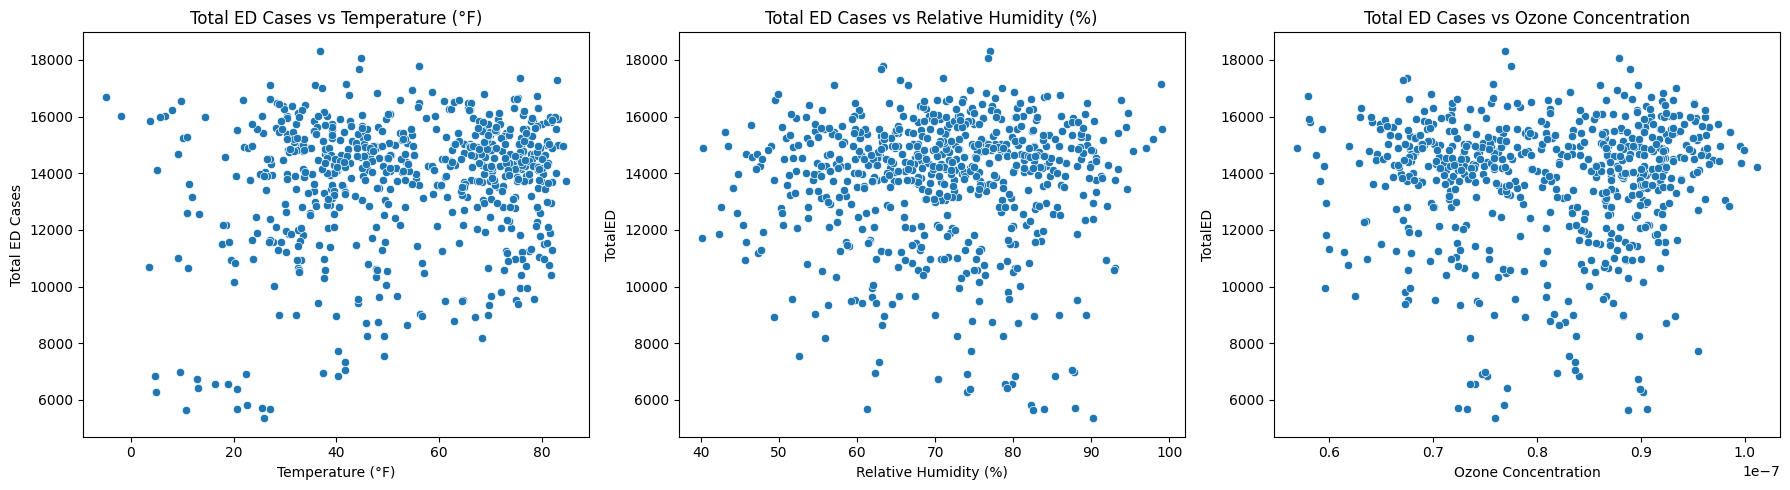

In [25]:
# Scatter plots for basic relationships
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(x='Ta_F', y='TotalED', data=merged_df)
plt.title('Total ED Cases vs Temperature (°F)')
plt.xlabel('Temperature (°F)')
plt.ylabel('Total ED Cases')

plt.subplot(1, 3, 2)
sns.scatterplot(x='r', y='TotalED', data=merged_df)
plt.title('Total ED Cases vs Relative Humidity (%)')
plt.xlabel('Relative Humidity (%)')

plt.subplot(1, 3, 3)
sns.scatterplot(x='o3', y='TotalED', data=merged_df)
plt.title('Total ED Cases vs Ozone Concentration')
plt.xlabel('Ozone Concentration')

plt.tight_layout()
plt.show()

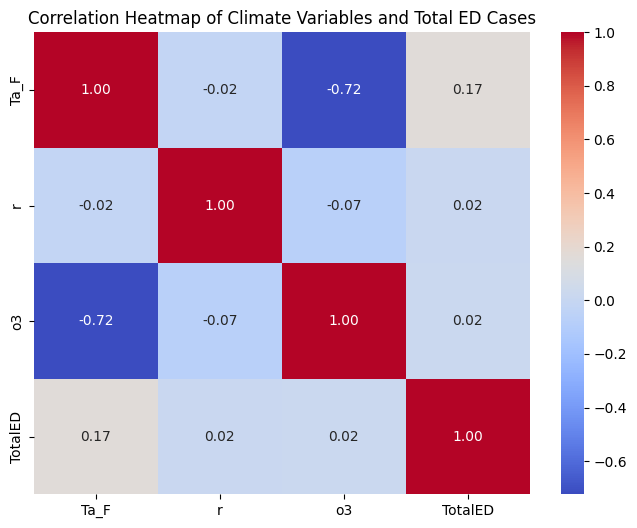

In [26]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
corr = merged_df[['Ta_F', 'r', 'o3', 'TotalED']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Climate Variables and Total ED Cases')
plt.show()

In [27]:
merged_df.set_index('valid_time', inplace=True)

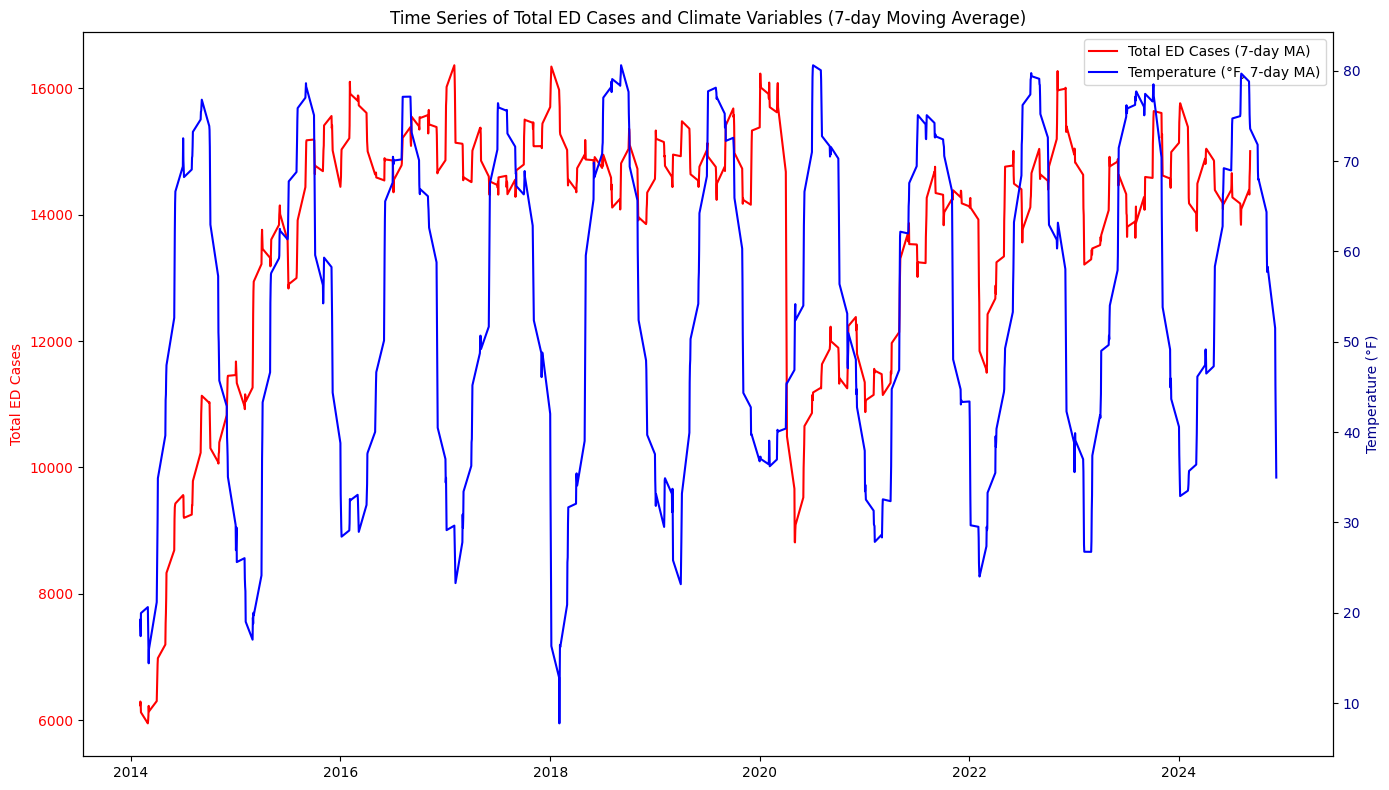

In [28]:
# Time series plot with moving averages
# merged_df['date'] = pd.to_datetime(merged_df['valid_time'])


# Calculate 7-day moving averages
merged_df['total_ED_MA7'] = merged_df['TotalED'].rolling(window=7).mean()
merged_df['Temperature_F_MA7'] = merged_df['Ta_F'].rolling(window=7).mean()
merged_df['Relative_Humidity_MA7'] = merged_df['r'].rolling(window=7).mean()

# 3. Time series plot with moving averages and dual y-axis
plt.figure(figsize=(14, 8))

# Primary y-axis for ED cases
ax1 = plt.gca()
ax1.plot(merged_df.index, merged_df['total_ED_MA7'], label='Total ED Cases (7-day MA)', color='red')
ax1.set_ylabel('Total ED Cases', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Secondary y-axis for climate variables
ax2 = ax1.twinx()
ax2.plot(merged_df.index, merged_df['Temperature_F_MA7'], label='Temperature (°F, 7-day MA)', color='blue')
# ax2.plot(merged_df.index, merged_df['Relative_Humidity_MA7'], label='Relative Humidity (%, 7-day MA)', color='green')
ax2.set_ylabel('Temperature (°F)', color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')

# Title and legend
plt.title('Time Series of Total ED Cases and Climate Variables (7-day Moving Average)')
plt.xlabel('Date')

# Create a combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

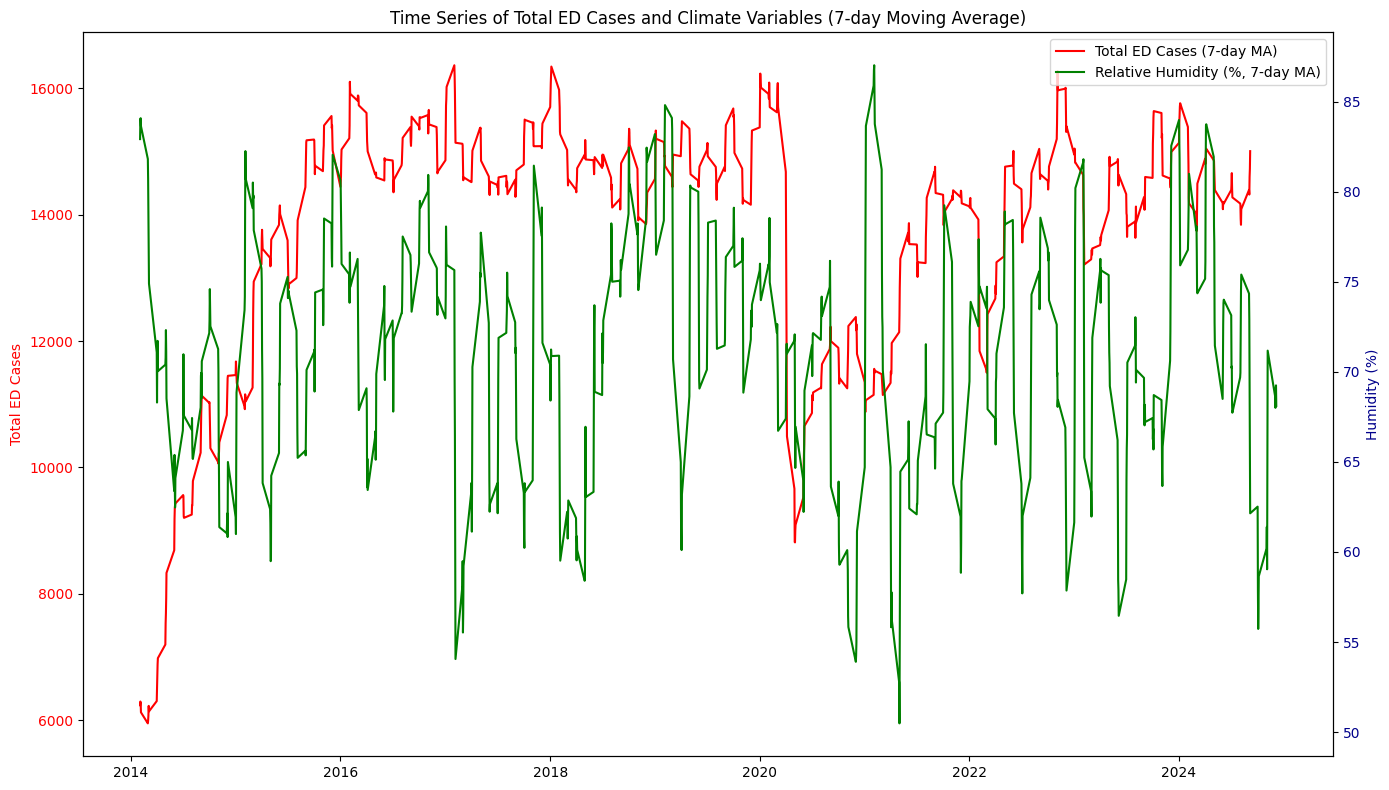

In [29]:
# Time series plot with moving averages and dual y-axis
plt.figure(figsize=(14, 8))

# Primary y-axis for ED cases
ax1 = plt.gca()
ax1.plot(merged_df.index, merged_df['total_ED_MA7'], label='Total ED Cases (7-day MA)', color='red')
ax1.set_ylabel('Total ED Cases', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Secondary y-axis for climate variables
ax2 = ax1.twinx()
# ax2.plot(merged_df.index, merged_df['Temperature_F_MA7'], label='Temperature (°F, 7-day MA)', color='blue')
ax2.plot(merged_df.index, merged_df['Relative_Humidity_MA7'], label='Relative Humidity (%, 7-day MA)', color='green')
ax2.set_ylabel('Humidity (%)', color='darkblue')
ax2.tick_params(axis='y', labelcolor='darkblue')

# Title and legend
plt.title('Time Series of Total ED Cases and Climate Variables (7-day Moving Average)')
plt.xlabel('Date')

# Create a combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

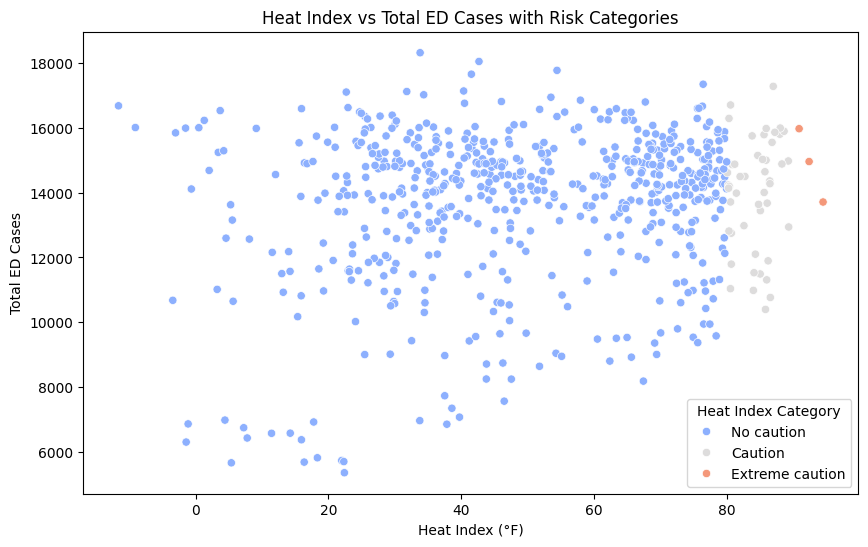

In [30]:
# Scatter plot Heat Index vs total ED cases, color-coded by risk category
plt.figure(figsize=(10, 6))
sns.scatterplot(x='HI', y='TotalED', hue='HI_Category', data=merged_df, palette='coolwarm')
plt.title('Heat Index vs Total ED Cases with Risk Categories')
plt.xlabel('Heat Index (°F)')
plt.ylabel('Total ED Cases')
plt.legend(title='Heat Index Category')
plt.show()

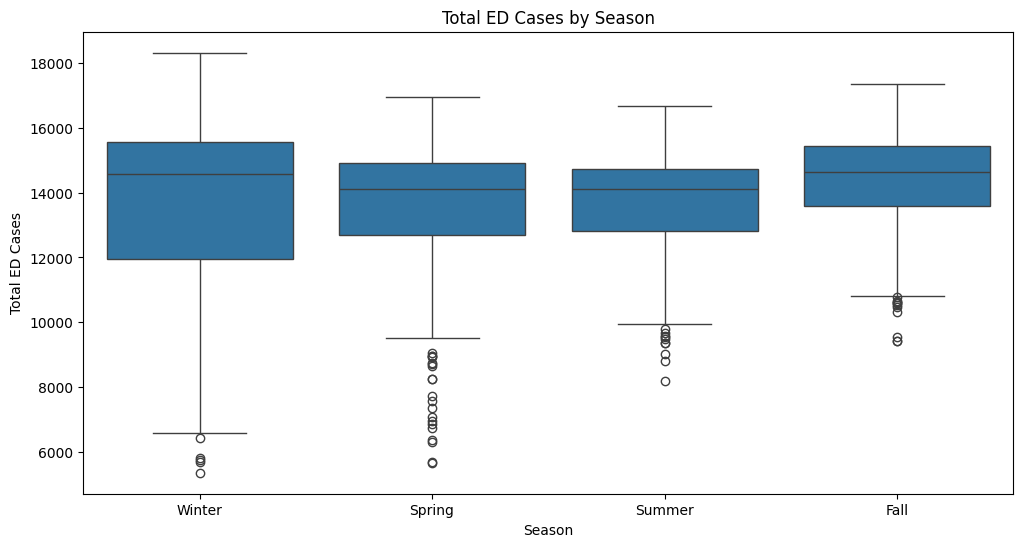

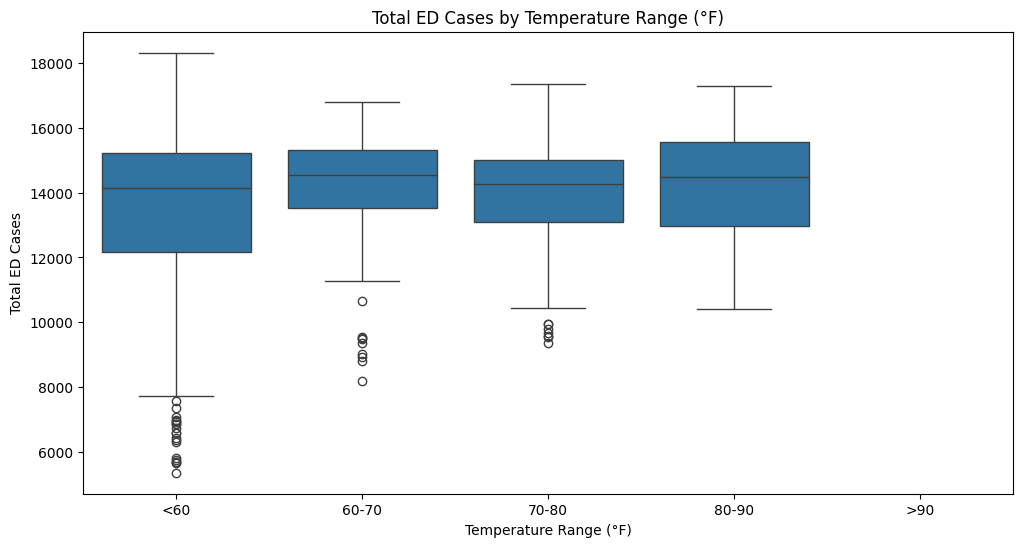

In [31]:
# Seasonal and temperature range analysis
merged_df['month'] = merged_df.index.month

# Define seasons
seasons = {12: 'Winter', 1: 'Winter', 2: 'Winter',
           3: 'Spring', 4: 'Spring', 5: 'Spring',
           6: 'Summer', 7: 'Summer', 8: 'Summer',
           9: 'Fall', 10: 'Fall', 11: 'Fall'}
merged_df['season'] = merged_df['month'].map(seasons)

# Define temperature bins (°F)
temp_bins = [0, 60, 70, 80, 90, 110]
temp_labels = ['<60', '60-70', '70-80', '80-90', '>90']
merged_df['temp_range'] = pd.cut(merged_df['Ta_F'], bins=temp_bins, labels=temp_labels, right=False)

# Boxplot of total ED cases by season
plt.figure(figsize=(12, 6))
sns.boxplot(x='season', y='TotalED', data=merged_df, order=['Winter', 'Spring', 'Summer', 'Fall'])
plt.title('Total ED Cases by Season')
plt.xlabel('Season')
plt.ylabel('Total ED Cases')
plt.show()

# Boxplot of total ED cases by temperature range
plt.figure(figsize=(12, 6))
sns.boxplot(x='temp_range', y='TotalED', data=merged_df)
plt.title('Total ED Cases by Temperature Range (°F)')
plt.xlabel('Temperature Range (°F)')
plt.ylabel('Total ED Cases')
plt.show()

## HI vs other Variables

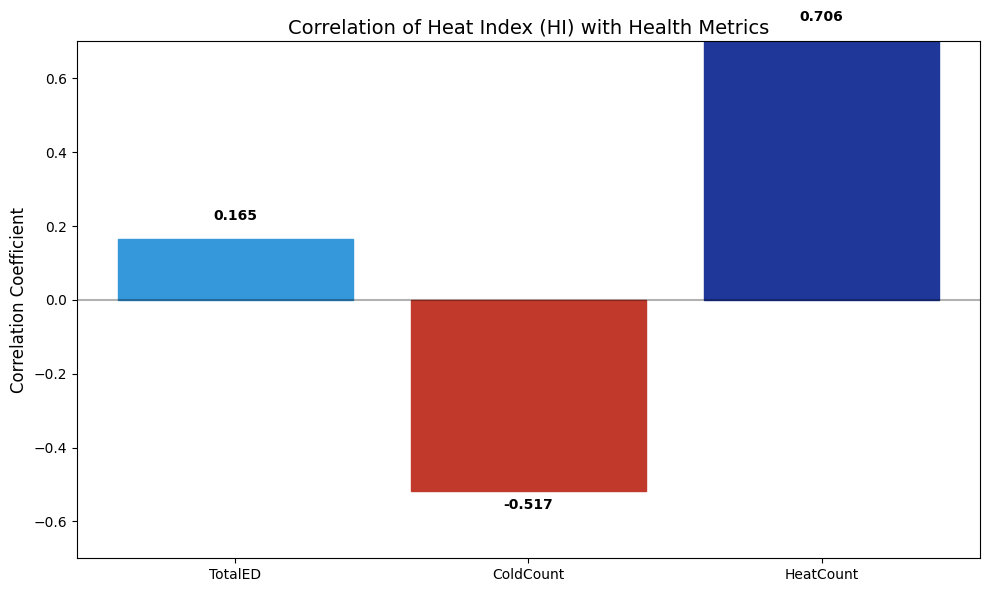

In [32]:
# Create a correlation bar chart
variables = ['TotalED', 'ColdCount', 'HeatCount']
correlations = [0.1653, -0.517134, 0.705570]

plt.figure(figsize=(10, 6))
bars = plt.bar(variables, correlations, color=['#3498db', '#2ecc71', '#e74c3c'])

# Color the bars based on correlation strength
for i, bar in enumerate(bars):
    if correlations[i] < -0.5:
        bar.set_color('#c0392b')  # Strong negative - dark red
    elif correlations[i] < -0.3:
        bar.set_color('#e74c3c')  # Moderate negative - red
    elif correlations[i] < 0:
        bar.set_color('#f39c12')  # Weak negative - orange
    elif correlations[i] < 0.3:
        bar.set_color('#3498db')  # Weak positive - light blue
    elif correlations[i] < 0.5:
        bar.set_color('#2980b9')  # Moderate positive - blue
    else:
        bar.set_color('#1e3799')  # Strong positive - dark blue

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Correlation of Heat Index (HI) with Health Metrics', fontsize=14)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.ylim(-0.7, 0.7)

# Add correlation values on top of bars
for i, v in enumerate(correlations):
    plt.text(i, v + (0.05 if v >= 0 else -0.05), 
             f"{v:.3f}", 
             ha='center', 
             fontweight='bold',
             color='black')

plt.tight_layout()
plt.show()


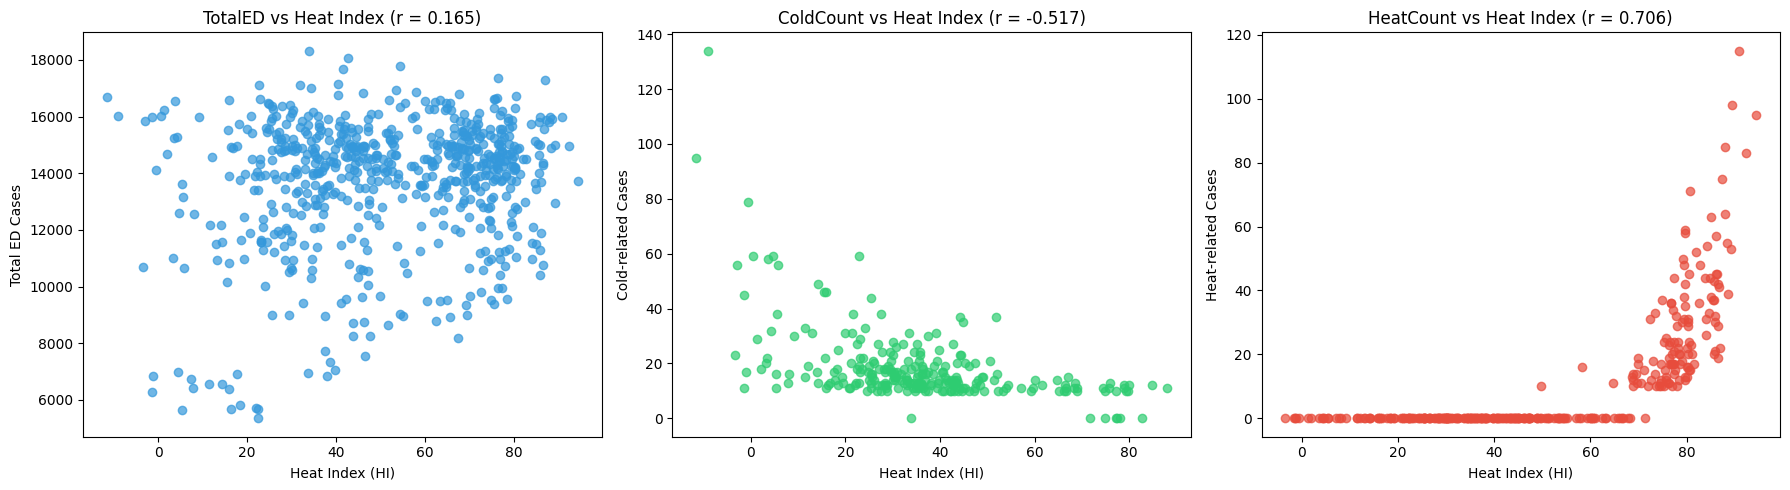

In [33]:
# Create scatter plots

hi_values = merged_df['HI']
totalED = merged_df['TotalED']
coldCount = merged_df['ColdCount']
heatCount = merged_df['HeatCount']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# TotalED vs HI
axes[0].scatter(hi_values, totalED, alpha=0.7, color='#3498db')
axes[0].set_title(f'TotalED vs Heat Index (r = {0.1653:.3f})', fontsize=12)
axes[0].set_xlabel('Heat Index (HI)', fontsize=10)
axes[0].set_ylabel('Total ED Cases', fontsize=10)
z = np.polyfit(hi_values, totalED, 1)
p = np.poly1d(z)
axes[0].plot(hi_values, p(hi_values), "r--", alpha=0.7)

# ColdCount vs HI
axes[1].scatter(hi_values, coldCount, alpha=0.7, color='#2ecc71')
axes[1].set_title(f'ColdCount vs Heat Index (r = {-0.517134:.3f})', fontsize=12)
axes[1].set_xlabel('Heat Index (HI)', fontsize=10)
axes[1].set_ylabel('Cold-related Cases', fontsize=10)
z = np.polyfit(hi_values, coldCount, 1)
p = np.poly1d(z)
axes[1].plot(hi_values, p(hi_values), "r--", alpha=0.7)

# HeatCount vs HI
axes[2].scatter(hi_values, heatCount, alpha=0.7, color='#e74c3c')
axes[2].set_title(f'HeatCount vs Heat Index (r = {0.705570:.3f})', fontsize=12)
axes[2].set_xlabel('Heat Index (HI)', fontsize=10)
axes[2].set_ylabel('Heat-related Cases', fontsize=10)
z = np.polyfit(hi_values, heatCount, 1)
p = np.poly1d(z)
axes[2].plot(hi_values, p(hi_values), "r--", alpha=0.7)

plt.tight_layout()
plt.show()

In [35]:
merged_df.head()

,t,q,r,o3,Ta_F,HI,HI_Category,ColdPct,ColdCount,HeatPct,HeatCount,TotalED,total_ED_MA7,Temperature_F_MA7,Relative_Humidity_MA7,month,season,temp_range
valid_time,,,,,,,,,,,,,,,,,,
2014-01-01,264.456329,0.001532,79.843132,7.397769e-08,16.351404,11.439172,No caution,0.228450,15.0,0.0,0.0,6566.0,NaN,NaN,NaN,1,Winter,<60
2014-01-02,265.899933,0.001696,78.994781,7.350549e-08,18.949890,14.257634,No caution,0.197869,13.0,0.0,0.0,6570.0,NaN,NaN,NaN,1,Winter,<60
2014-01-03,257.979340,0.000905,85.374626,7.515862e-08,4.692822,-1.125289,No caution,0.247958,17.0,0.0,0.0,6856.0,NaN,NaN,NaN,1,Winter,<60
2014-01-04,267.798981,0.001803,74.083138,7.473366e-08,22.368176,17.786901,No caution,0.202458,14.0,0.0,0.0,6915.0,NaN,NaN,NaN,1,Winter,<60
2014-01-05,269.750580,0.002633,90.248962,7.594437e-08,25.881054,22.410861,No caution,0.336574,18.0,0.0,0.0,5348.0,NaN,NaN,NaN,1,Winter,<60


In [36]:
from matplotlib.colors import LinearSegmentedColormap


def calculate_correlations_by_period(df, target_vars, reference_var='HI'):
    """
    Calculate correlations between reference_var and target_vars for each time period
    """
    # Extract year-month from date
    df['year_month'] = df.index.strftime('%Y-%m')
    
    # Initialize a DataFrame to store correlations
    periods = sorted(df['year_month'].unique())
    corr_df = pd.DataFrame(index=periods, columns=target_vars)
    
    # Calculate correlation for each period
    for period in periods:
        period_data = df[df['year_month'] == period]
        if len(period_data) >= 3:  # Ensure enough data points for correlation
            for var in target_vars:
                corr_df.loc[period, var] = period_data[[reference_var, var]].corr().iloc[0, 1]
    
    return corr_df

# Calculate correlations
target_variables = ['TotalED', 'ColdCount', 'HeatCount']
corr_by_time = calculate_correlations_by_period(merged_df, target_variables)
corr_by_time = corr_by_time.fillna(0)


/var/folders/yr/ccrg_j914ln8wydhc308crs00000gp/T/ipykernel_94715/647986156.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_by_time = corr_by_time.fillna(0)


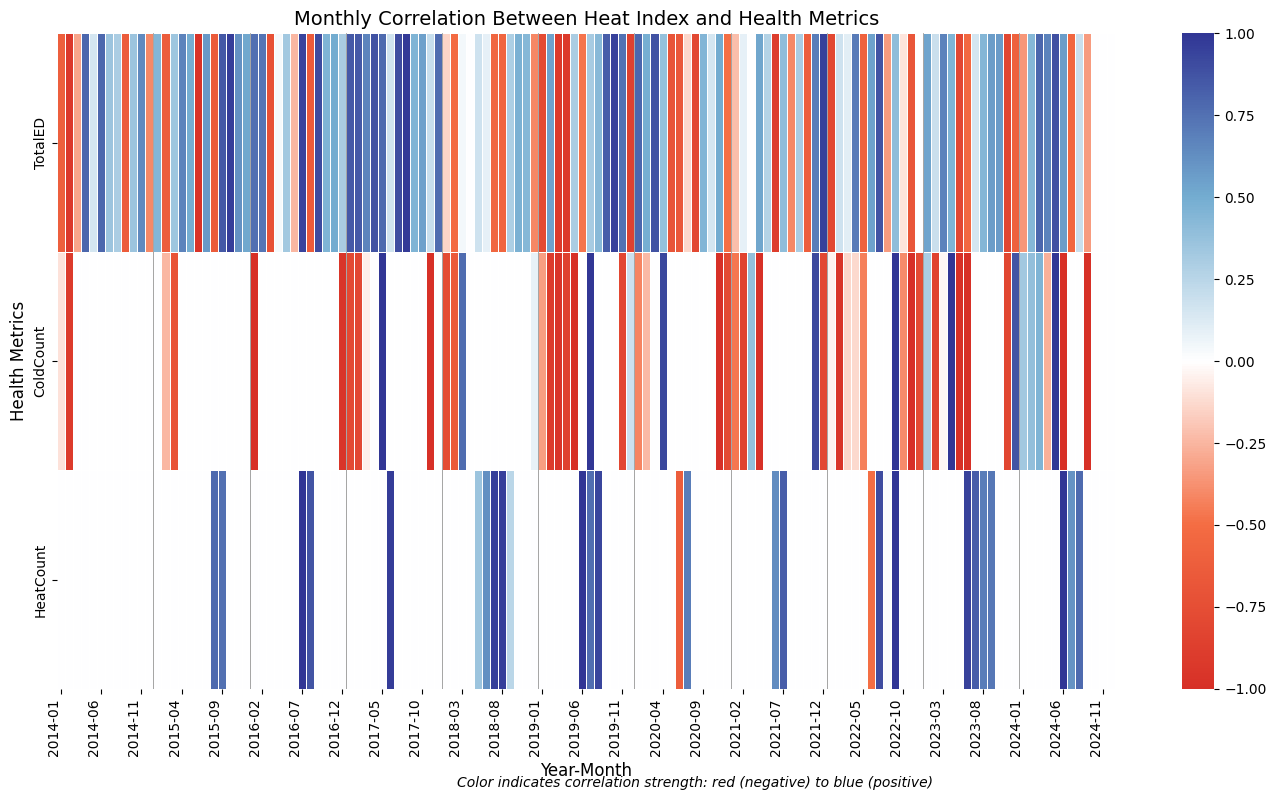

In [39]:
# Create a cleaner heatmap
plt.figure(figsize=(14, 8))

# Use a simpler, more contrasting color palette
custom_cmap = LinearSegmentedColormap.from_list('custom_diverging',
                                               ['#d73027', '#f46d43', '#ffffff', '#74add1', '#313695'])

# Split into three separate heatmaps (one per row)
health_metrics = ['TotalED', 'ColdCount', 'HeatCount']
corr_subset = corr_by_time[health_metrics].T

# Plot with cleaner formatting
sns.heatmap(corr_subset, cmap=custom_cmap, center=0, vmin=-1, vmax=1, 
            annot=False, fmt=".2f", linewidths=0.5,
            annot_kws={"size": 9})

# Fix date formatting on x-axis
months = corr_by_time.index
plt.xticks(np.arange(len(months))+0.5,
           [pd.to_datetime(m).strftime('%Y-%m') for m in months],
           rotation=90, ha='right')
xticks = plt.gca().get_xticks()
plt.xticks(xticks[::5])

# Add better spacing and labels
plt.title('Monthly Correlation Between Heat Index and Health Metrics', fontsize=14)
plt.ylabel('Health Metrics', fontsize=12)
plt.xlabel('Year-Month', fontsize=12)

# Add vertical lines between years for better readability
years = [pd.to_datetime(m).year for m in months]
for i in range(1, len(years)):
    if years[i] > years[i-1]:
        plt.axvline(x=i, color='black', linestyle='-', linewidth=0.5, alpha=0.5)


plt.figtext(0.5, 0.01, 'Color indicates correlation strength: red (negative) to blue (positive)', 
            ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.show()

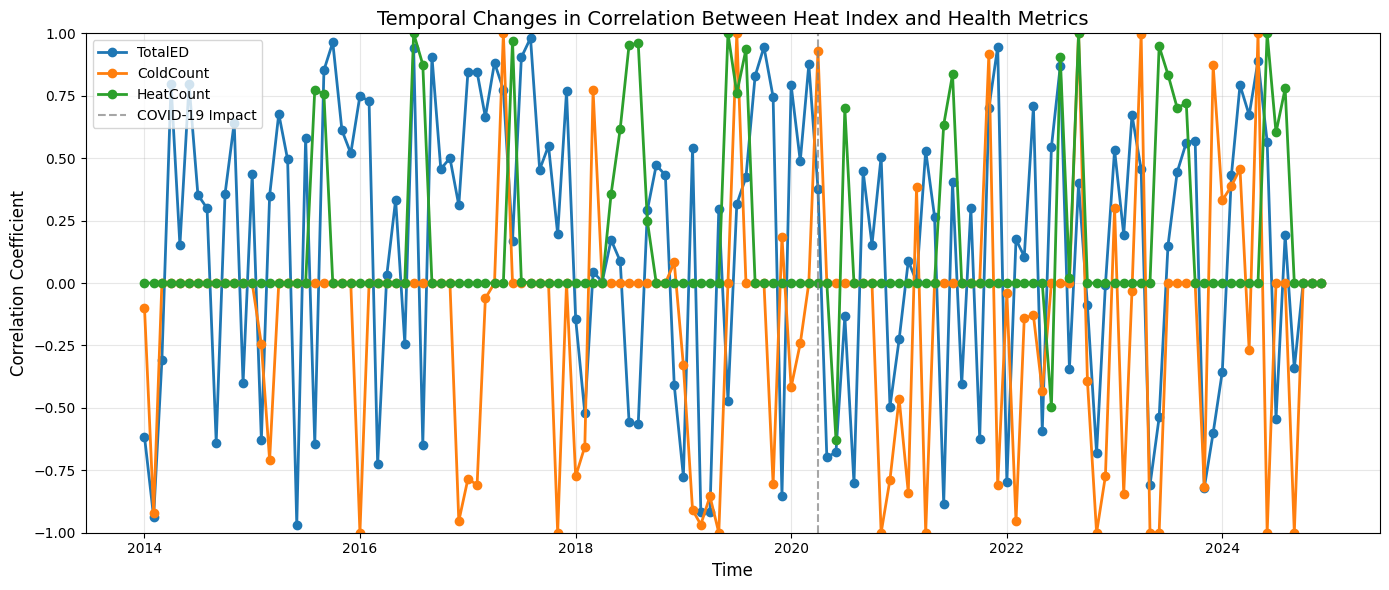

In [40]:
# Create a line plot showing correlation trends over time
plt.figure(figsize=(14, 6))

# Convert index to datetime for proper time plotting
corr_by_time.index = pd.to_datetime(corr_by_time.index + '-01')

# Plot each correlation as a line
for var in target_variables:
    plt.plot(corr_by_time.index, corr_by_time[var], marker='o', linewidth=2, label=var)

# Add COVID period indicator (around April 2020)
plt.axvline(pd.to_datetime('2020-04-01'), color='gray', linestyle='--', alpha=0.7, label='COVID-19 Impact')

plt.title('Temporal Changes in Correlation Between Heat Index and Health Metrics', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.ylim(-1, 1)
plt.tight_layout()
plt.show()


## Merge with UTCI and MRT

In [41]:
merged_df.head()

,t,q,r,o3,Ta_F,HI,HI_Category,ColdPct,ColdCount,HeatPct,HeatCount,TotalED,total_ED_MA7,Temperature_F_MA7,Relative_Humidity_MA7,month,season,temp_range,year_month
valid_time,,,,,,,,,,,,,,,,,,,
2014-01-01,264.456329,0.001532,79.843132,7.397769e-08,16.351404,11.439172,No caution,0.228450,15.0,0.0,0.0,6566.0,NaN,NaN,NaN,1,Winter,<60,2014-01
2014-01-02,265.899933,0.001696,78.994781,7.350549e-08,18.949890,14.257634,No caution,0.197869,13.0,0.0,0.0,6570.0,NaN,NaN,NaN,1,Winter,<60,2014-01
2014-01-03,257.979340,0.000905,85.374626,7.515862e-08,4.692822,-1.125289,No caution,0.247958,17.0,0.0,0.0,6856.0,NaN,NaN,NaN,1,Winter,<60,2014-01
2014-01-04,267.798981,0.001803,74.083138,7.473366e-08,22.368176,17.786901,No caution,0.202458,14.0,0.0,0.0,6915.0,NaN,NaN,NaN,1,Winter,<60,2014-01
2014-01-05,269.750580,0.002633,90.248962,7.594437e-08,25.881054,22.410861,No caution,0.336574,18.0,0.0,0.0,5348.0,NaN,NaN,NaN,1,Winter,<60,2014-01


In [42]:
df1 = merged_df.drop(columns=['total_ED_MA7', 'Temperature_F_MA7', 'Relative_Humidity_MA7', 'month', 'season', 'temp_range', 'year_month'], axis=1)

In [43]:
df1.reset_index(inplace=True)

In [44]:
df1.head()

,valid_time,t,q,r,o3,Ta_F,HI,HI_Category,ColdPct,ColdCount,HeatPct,HeatCount,TotalED
0,2014-01-01,264.456329,0.001532,79.843132,7.397769e-08,16.351404,11.439172,No caution,0.228450,15.0,0.0,0.0,6566.0
1,2014-01-02,265.899933,0.001696,78.994781,7.350549e-08,18.949890,14.257634,No caution,0.197869,13.0,0.0,0.0,6570.0
2,2014-01-03,257.979340,0.000905,85.374626,7.515862e-08,4.692822,-1.125289,No caution,0.247958,17.0,0.0,0.0,6856.0
3,2014-01-04,267.798981,0.001803,74.083138,7.473366e-08,22.368176,17.786901,No caution,0.202458,14.0,0.0,0.0,6915.0
4,2014-01-05,269.750580,0.002633,90.248962,7.594437e-08,25.881054,22.410861,No caution,0.336574,18.0,0.0,0.0,5348.0


In [45]:
# List all your NetCDF files
files = sorted(glob.glob("data/climate/utci_mrt_variables/*/*.nc"))

# Open each file separately 
datasets = [xr.open_dataset(f) for f in files]
combined = xr.combine_by_coords(datasets, combine_attrs="override")
df = combined.to_dataframe()
df.reset_index(inplace=True)
df['date'] = df['time'].dt.floor('d')
# Aggregate to daily data by date, lat, lon (mean of mrt and utci)
df_daily = df.groupby(['date']).agg({'mrt': 'mean', 'utci': 'mean'}).reset_index()
df_daily['mrt_F'] = (df_daily['mrt'] - 273.15) * 9/5 + 32
df_daily.drop(['mrt'], axis=1, inplace=True)
df_daily.head()

,date,utci,mrt_F
0,2014-01-01,252.168564,22.816309
1,2014-01-02,250.445007,31.878107
2,2014-01-03,243.619492,13.846630
3,2014-01-04,247.278702,26.074524
4,2014-01-05,252.211487,29.039459


In [46]:
df_final = pd.merge(df1, df_daily, left_on='valid_time', right_on='date', how='left')
df_final.drop(['date', 't'], axis=1, inplace=True)
df_final.head()

,valid_time,q,r,o3,Ta_F,HI,HI_Category,ColdPct,ColdCount,HeatPct,HeatCount,TotalED,utci,mrt_F
0,2014-01-01,0.001532,79.843132,7.397769e-08,16.351404,11.439172,No caution,0.228450,15.0,0.0,0.0,6566.0,252.168564,22.816309
1,2014-01-02,0.001696,78.994781,7.350549e-08,18.949890,14.257634,No caution,0.197869,13.0,0.0,0.0,6570.0,250.445007,31.878107
2,2014-01-03,0.000905,85.374626,7.515862e-08,4.692822,-1.125289,No caution,0.247958,17.0,0.0,0.0,6856.0,243.619492,13.846630
3,2014-01-04,0.001803,74.083138,7.473366e-08,22.368176,17.786901,No caution,0.202458,14.0,0.0,0.0,6915.0,247.278702,26.074524
4,2014-01-05,0.002633,90.248962,7.594437e-08,25.881054,22.410861,No caution,0.336574,18.0,0.0,0.0,5348.0,252.211487,29.039459


## Model Building

In [47]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, r2_score

In [48]:
df_final.count()

valid_time     660
q              660
r              660
o3             660
Ta_F           660
HI             660
HI_Category    660
ColdPct        250
ColdCount      250
HeatPct        326
HeatCount      326
TotalED        645
utci           660
mrt_F          660
dtype: int64

In [49]:
# Fill missing target values with 0
df_final['HeatCount'] = df_final['HeatCount'].interpolate(method='linear', limit_direction='both')
df_final['ColdCount'] = df_final['ColdCount'].interpolate(method='linear', limit_direction='both')
# df_final[['ColdCount', 'HeatCount']] = df_final[['ColdCount', 'HeatCount']].fillna(0)

# Encode HI_Category to ordinal values
category_map = {
    "No caution": 0,
    "Caution": 1,
    "Extreme caution": 2,
    "Danger": 3,
    "Extreme danger": 4
}
df_final['HI_cat_code'] = df_final['HI_Category'].map(category_map)


# Create interaction and lag features
df_final['temp_humidity'] = df_final['Ta_F'] * df_final['r']
df_final['HI_minus_TaF'] = df_final['HI'] - df_final['Ta_F']
df_final['HI_lag1'] = df_final['HI'].shift(1).fillna(method='bfill')  # lag and fill
df_final.head()

/var/folders/yr/ccrg_j914ln8wydhc308crs00000gp/T/ipykernel_94715/1459224231.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_final['HI_lag1'] = df_final['HI'].shift(1).fillna(method='bfill')  # lag and fill


,valid_time,q,r,o3,Ta_F,HI,HI_Category,ColdPct,ColdCount,HeatPct,HeatCount,TotalED,utci,mrt_F,HI_cat_code,temp_humidity,HI_minus_TaF,HI_lag1
0,2014-01-01,0.001532,79.843132,7.397769e-08,16.351404,11.439172,No caution,0.228450,15.0,0.0,0.0,6566.0,252.168564,22.816309,0,1305.547363,-4.912232,11.439172
1,2014-01-02,0.001696,78.994781,7.350549e-08,18.949890,14.257634,No caution,0.197869,13.0,0.0,0.0,6570.0,250.445007,31.878107,0,1496.942383,-4.692256,11.439172
2,2014-01-03,0.000905,85.374626,7.515862e-08,4.692822,-1.125289,No caution,0.247958,17.0,0.0,0.0,6856.0,243.619492,13.846630,0,400.647888,-5.818110,14.257634
3,2014-01-04,0.001803,74.083138,7.473366e-08,22.368176,17.786901,No caution,0.202458,14.0,0.0,0.0,6915.0,247.278702,26.074524,0,1657.104614,-4.581275,-1.125289
4,2014-01-05,0.002633,90.248962,7.594437e-08,25.881054,22.410861,No caution,0.336574,18.0,0.0,0.0,5348.0,252.211487,29.039459,0,2335.738281,-3.470193,17.786901


In [50]:
# Define Features and Targets
# -------------------------------
features = ['Ta_F', 'q', 'r', 'o3', 'HI', 'HI_cat_code', 'temp_humidity', 'HI_minus_TaF', 'HI_lag1']
X = df_final[features]
y_cold = df_final['ColdCount']
y_heat = df_final['HeatCount']

In [51]:
# Cross-Validation
# -------------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

cv_r2_cold = cross_val_score(rf_model, X, y_cold, cv=kf, scoring='r2')
cv_rmse_cold = np.sqrt(-cross_val_score(rf_model, X, y_cold, cv=kf, scoring='neg_mean_squared_error'))

cv_r2_heat = cross_val_score(rf_model, X, y_heat, cv=kf, scoring='r2')
cv_rmse_heat = np.sqrt(-cross_val_score(rf_model, X, y_heat, cv=kf, scoring='neg_mean_squared_error'))

In [54]:
def plot_residuals(model, X, y_true, title):
    y_pred = model.predict(X)
    residuals = y_true - y_pred

    plt.figure(figsize=(8, 4))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals (Actual - Predicted)")
    plt.title(f"Residual Plot: {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

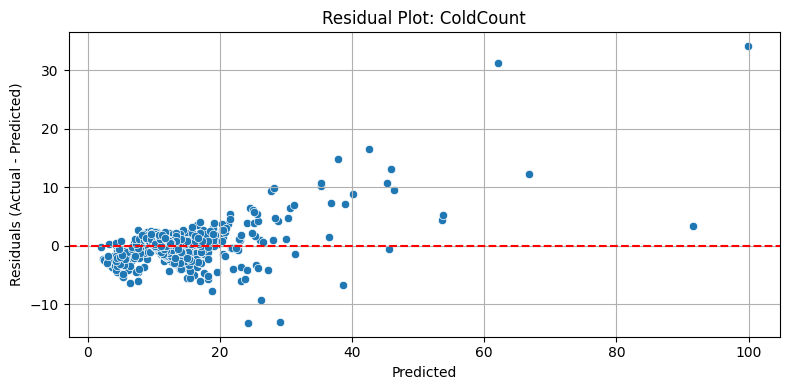

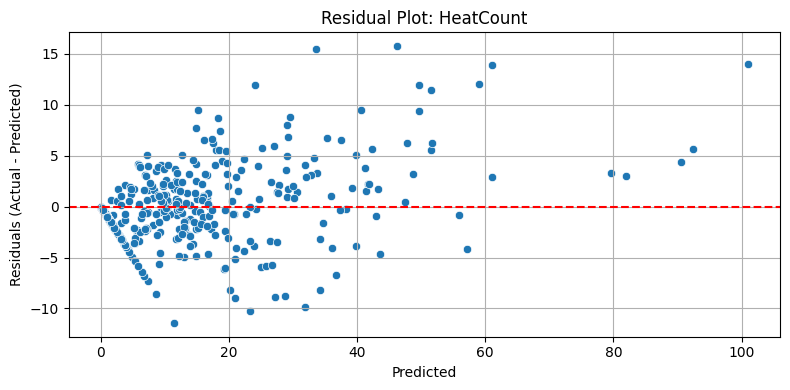

In [55]:
# Feature Importance (ColdCount)
# -------------------------------
rf_model.fit(X, y_cold)
plot_residuals(rf_model, X, y_cold, "ColdCount")
cold_feature_importance = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)

# Feature Importance (HeatCount)
# -------------------------------
rf_model.fit(X, y_heat)
plot_residuals(rf_model, X, y_heat, "HeatCount")
heat_feature_importance = pd.Series(rf_model.feature_importances_, index=features).sort_values(ascending=False)

In [57]:
# Print Results
# -------------------------------
print("Cross-Validated R² and RMSE")
print(f"ColdCount - R²: {cv_r2_cold.mean():.3f}, RMSE: {cv_rmse_cold.mean():.3f}")
print(f"HeatCount - R²: {cv_r2_heat.mean():.3f}, RMSE: {cv_rmse_heat.mean():.3f}")

print("\nTop Features for ColdCount:")
print(cold_feature_importance)

print("\nTop Features for HeatCount:")
print(heat_feature_importance)

Cross-Validated R² and RMSE
ColdCount - R²: 0.228, RMSE: 8.836
HeatCount - R²: 0.727, RMSE: 7.893

Top Features for ColdCount:
Ta_F             0.297334
o3               0.142398
q                0.119928
temp_humidity    0.115643
HI_lag1          0.111854
HI               0.085216
r                0.082659
HI_minus_TaF     0.044848
HI_cat_code      0.000121
dtype: float64

Top Features for HeatCount:
HI               0.323827
HI_minus_TaF     0.319266
HI_lag1          0.112934
Ta_F             0.108976
q                0.052519
o3               0.040197
r                0.020522
temp_humidity    0.019255
HI_cat_code      0.002504
dtype: float64


In [ ]:
# Compute residuals
residuals_cold = y_test_cold - y_pred_cold
residuals_heat = y_test_heat - y_pred_heat

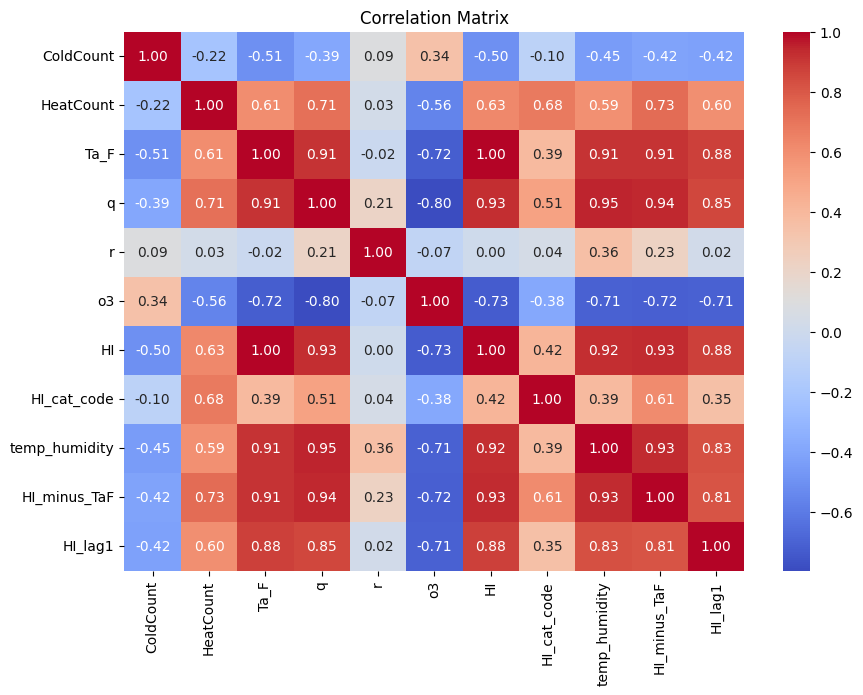

In [150]:
corr = df_final[['ColdCount', 'HeatCount'] + features].corr()

plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

In [60]:
from sklearn.feature_selection import RFE

# RFE for ColdCount
model = LinearRegression()
rfe_cold = RFE(model, n_features_to_select=5)
rfe_cold.fit(X, df_final['ColdCount'])
selected_cold = X.columns[rfe_cold.support_].tolist()

# RFE for HeatCount
rfe_heat = RFE(model, n_features_to_select=5)
rfe_heat.fit(X, df_final['HeatCount'])
selected_heat = X.columns[rfe_heat.support_].tolist()

print("Selected features for ColdCount:", selected_cold)
print("Selected features for HeatCount:", selected_heat)

Selected features for ColdCount: ['Ta_F', 'q', 'o3', 'HI', 'HI_cat_code']
Selected features for HeatCount: ['Ta_F', 'q', 'o3', 'HI', 'HI_cat_code']



ColdCount Model
R² Score: 0.268
RMSE: 7.669
Coefficients: {'Ta_F': np.float64(0.23390797220108564), 'q': np.float64(1336.107934729825), 'o3': np.float64(91064709.67691185), 'HI': np.float64(-0.6799916015189467), 'HI_cat_code': np.float64(2.6220990728469524)}


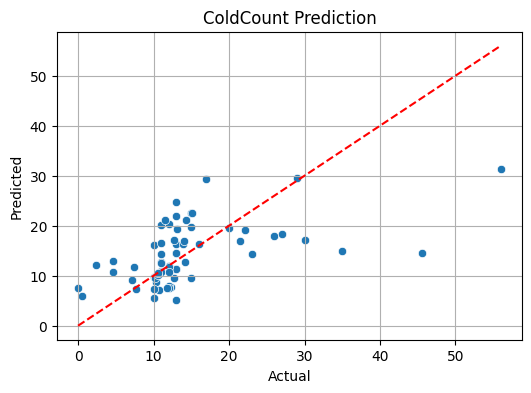

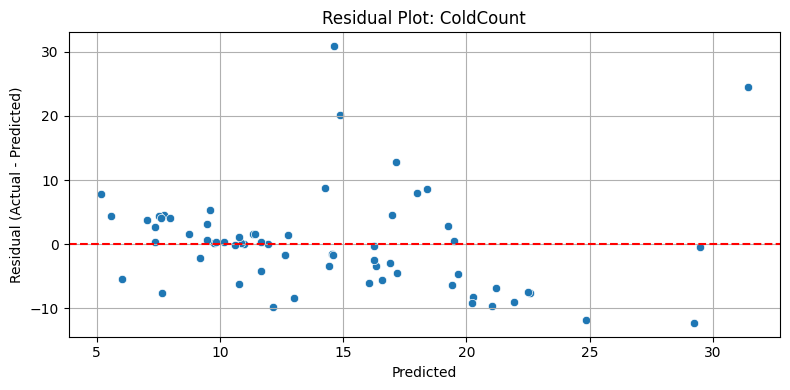


HeatCount Model
R² Score: 0.817
RMSE: 7.57
Coefficients: {'Ta_F': np.float64(-1.0022334384383826), 'q': np.float64(1672.4064833288423), 'o3': np.float64(-7857504.574510044), 'HI': np.float64(0.913962937783631), 'HI_cat_code': np.float64(18.330437082800383)}


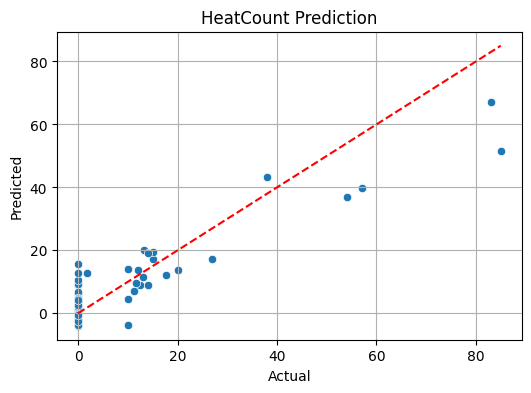

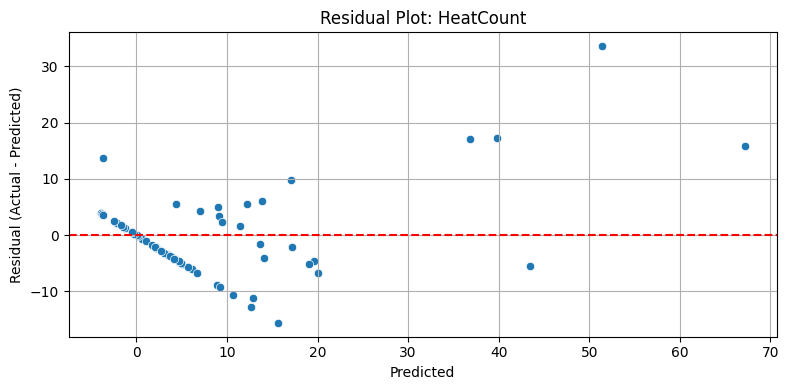

In [61]:
def train_and_evaluate(X, y, label):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\n{label} Model")
    print("R² Score:", round(r2_score(y_test, y_pred), 3))
    print("RMSE:", round(root_mean_squared_error(y_test, y_pred), 3))
    print("Coefficients:", dict(zip(X.columns, model.coef_)))

    # Plot actual vs predicted
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{label} Prediction')
    plt.grid(True)
    plt.show()

    plot_residuals(y_test, y_pred, f"{label}")

# ColdCount
X_cold = df_final[selected_cold]
y_cold = df_final['ColdCount']
train_and_evaluate(X_cold, y_cold, "ColdCount")

# HeatCount
X_heat = df_final[selected_heat]
y_heat = df_final['HeatCount']
train_and_evaluate(X_heat, y_heat, "HeatCount")

In [58]:
# Residual plot function
def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Predicted")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.title(f"Residual Plot: {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()